In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(phi1, phi2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    phi1, phi2 = phi1, phi2
    p1 = (2*phi1+phi2)/3. + cost
    p2 = (2*phi2+phi1)/3. + cost
    if phi1 <= 0 or phi2 <= 0:
        return 0,0
    
    return p1, p2
  
    
def calc_s(phi1, phi2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat = .5 + (p2 - p1)/(2.*cost)
    return s_hat


def calc_profits(phi1,phi2,cost, wtp, mc):
    phi1, phi2 = phi1, phi2
    s= calc_s(phi1, phi2, cost, wtp)
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    profits1, profits2 = s*(p1-phi1), (1-s)*(p2-phi2)
    mc1,mc2 = mc
    hosp_profit = s*(phi1-mc1) +  (1-s)*(phi2-mc2)
    
    if phi1 <= 0 or phi2 <= 0:
        return 0,0,0
    
    return hosp_profit, profits1, profits2

    
def outside_simlt(phi1, phi2, cost, wtp,  mc):
    """outside option in simult case
    assuming listprice high enough"""
    mc1,mc2 = mc
    
    s_hat = calc_s(phi1, phi2, cost, wtp) # s_hat with no recapture
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    #s_hat  = np.clip((cost + p2 - wtp)/cost,0,1) #s_hat with recapture
    
    return (1-s_hat)*(phi2 -mc2)


calc_profits(5,0 ,5, 26, [0,0])

(0, 0, 0)

In [3]:
#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    if outside == None:
        outside = outside_simlt(phi1, phi2,cost, wtp , mc)

    hosp_profit, profits1, profits2 = calc_profits(phi1, phi2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj

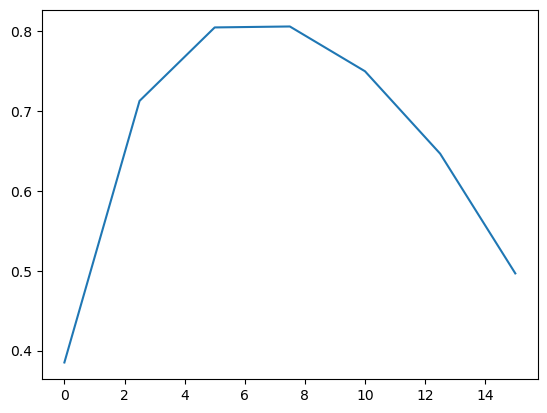

In [4]:
COST = 5
WTP = 25
MC = np.array([0,0])

plt.plot([i for i in np.linspace(0,3*COST,num=7)], 
         [-1*nash_in_nash(i, 4, COST,WTP,MC) for i in np.linspace(1,2*COST,num=7)])

In [5]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc, beta, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 10
MC = np.array([0,0])

print(bargain_helper(15,15, COST,WTP,MC,beta=.5))

[7.5]


In [6]:
def simult_bargain(phi1, phi2, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables, check on this...
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = 0,0
    maxiter = 20
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        
        outside1 = outside_simlt(phi10, phi20, cost, wtp,  mc)
        outside2 = outside_simlt(phi20, phi10, cost, wtp, mc[::-1])
        phi1 = bargain_helper(phi1, phi2, cost, wtp, mc, beta=betas[0],outside=outside1)
        phi2 = bargain_helper(phi2, phi1, cost, wtp, mc[::-1], beta=betas[1],outside=outside2)
        
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2

COST = 5
WTP  = 25
MC = np.array([0,0])
print(simult_bargain(2,2,COST,WTP,MC))
#print(simult_bargain(15,15,COST,WTP,MC,active=True))

(array([7.4999721]), array([7.50001272]))


In [7]:
def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = simult_bargain(10,10,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False)

print(compute_cov())

[[0.24292057 0.08922855]
 [0.08922855 0.23620974]]


In [11]:
def compute_solution(nobs=20):
    #mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    vs = np.random.uniform(low=26,high=26.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    x = np.concatenate(([vs],[lambdas])) #,mcs
    for i in range(nobs):
        phi = simult_bargain(10,10,lambdas[i],vs[i],np.array([0,0])) 
        phis.append(np.array(phi).flatten())
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)
    
print(compute_solution(nobs=10))

(array([-7.66523999e-06,  1.50003007e+00]), array([-2.13914592e-06,  1.50000454e+00]))


In [12]:
def compute_solution(nobs=20):
    
    #set up x variables to solve the model
    phis = []
    vs = np.random.uniform(low=25,high=26,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    x = np.concatenate(([vs],[lambdas],mcs))
    
    #generate a few solutions...
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,lambdas[i],vs[i],mcs[:,i]) 
        phis.append(np.array(phi).flatten())
        
    #do regression stuff to solve
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)

#coeffs are v, lambda, c1, c2
print(compute_solution(nobs=10))

(array([7.89065041e-07, 1.49999592e+00, 8.33335933e-01, 1.66641306e-01]), array([-5.32697186e-07,  1.50000009e+00,  1.66660990e-01,  8.33329702e-01]))


In [ ]:
#5/6 and 1/6...